# Structure Function science showcase

In [1]:
import tape
from tape import Ensemble
from tape.utils import ColumnMapper
from tape.analysis.structure_function.base_argument_container import StructureFunctionArgumentContainer
import eztao

import numpy as np
import matplotlib.pyplot as plt


## Introduction 

Structure function is often used to quantify the fluctuations or variations in a signal as a function of spatial or temporal separation. It is a method to analyze and describe the statistical properties of fluctuations within a dataset. In this tutorial, we will show how to use and employ structure function calculation as written in TAPE.

First, before we get to the structure function calculations, we want to create the data with known
temporal properties (and known structure function) so that we can verify our results. We will use the package `EzTao`, which enables us
to create high-quality lightcurves with known properties.
We will generate lightcurves with a property of damped random walk. Damped random walk differs from a standard random walk process 
by having an additional term that does not allow the process to venture too far away from its mean.
 
These lightcurves created in this fashion fully described with two parameters - amplitude and decorrelation scale.


Text(0, 0.5, 'magnitude [unit]')

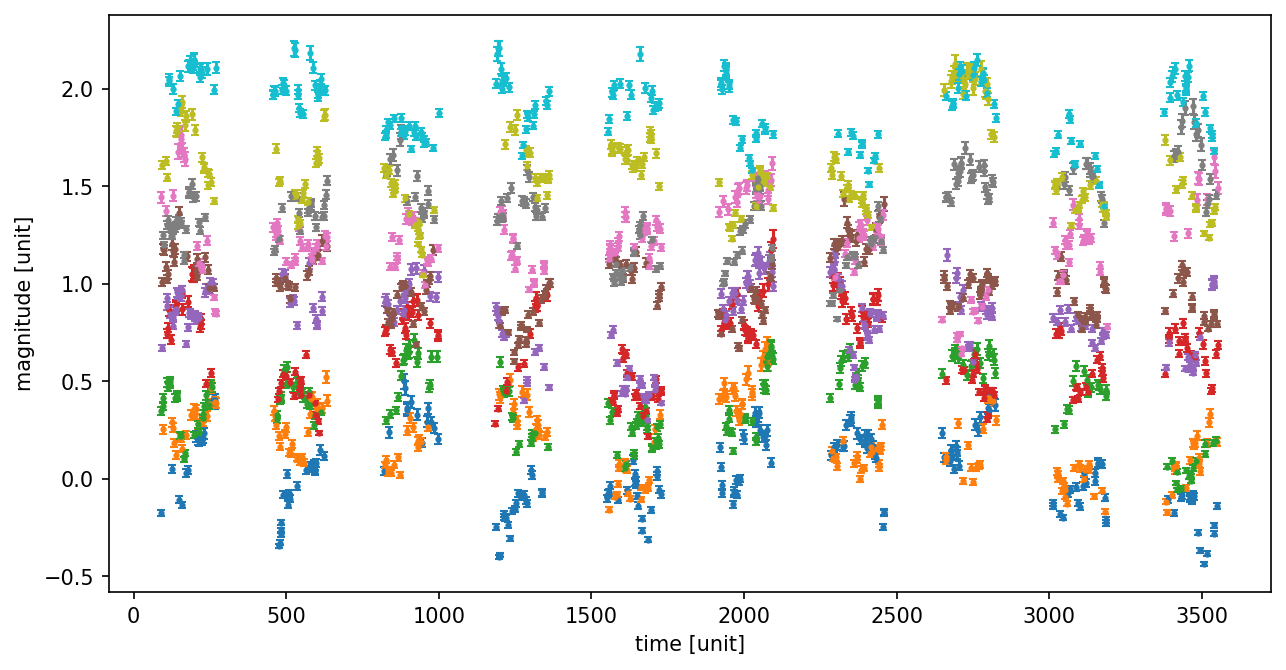

In [2]:
from eztao.carma import DRW_term
from eztao.ts import gpSimRand

# amp is RMS amplitude of the process and tau is the decorrelation timescale
amp = 0.2
tau = 100

# Create the kernel
DRW_kernel = DRW_term(np.log(amp), np.log(tau))

# specify how many lightcurves and observational details
num_light_curves = 100
snr = 10
duration_in_days = 365 * 10
num_observations = 200

# Generate `num_light_curves` lightcurves
# t, y, yerr are np.ndarray with shape = (num_light_curves, num_observations)
t, y, err = gpSimRand(
    carmaTerm=DRW_kernel,
    SNR=snr,
    duration=duration_in_days,
    N=num_observations,
    nLC=num_light_curves)

# pick 10 lightcurves at random and plot (with small offset for clarity)
sel_10 = np.random.choice(len(t), size=10, replace=False)
plt.figure(dpi=150, figsize=(10,5))
for i, j in enumerate(sel_10):
    plt.errorbar(t[j], y[j]+i*0.2, yerr=err[j], ls='', marker='.', ms=4, capsize=2)
plt.xlabel('time [unit]')
plt.ylabel('magnitude [unit]')

We now calculate the structure function for these 10 lightcurves independently. 
This can be achieved by direct use of `calc_sf2` function, which takes
times of the measurments, values of the measurments and the errors.
The default method for calculating structure functions is to compute the variance of all of the data pairs
in the time bin and subtract squared error of the measurements, i.e.,
$$
SF^2 = \frac{1}{P} \sum_{i,j>i}^{P} (m_i - m_j)^2 - \sigma_i^2-\sigma_j^2
$$
where the sum is over all $P$ measurements which are separate by a time lag, $m$ are the values of
measurements, and we are taking into account the measurement errors $\sigma$ of the individual data points.




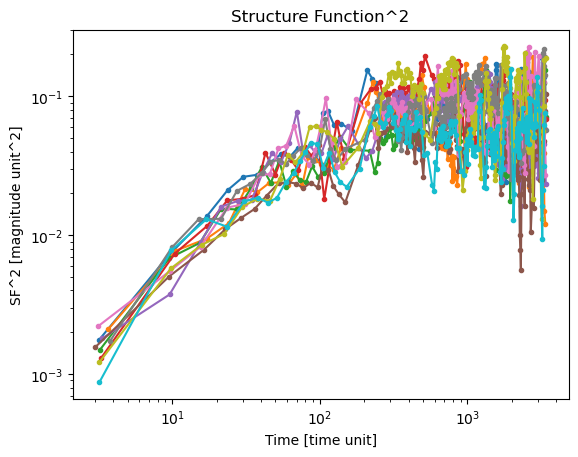

In [3]:
# We show here structure function for the same 10 lightcurves
plt.figure()
for i, j in enumerate(sel_10):
    res_basic = tape.analysis.calc_sf2(t[j], y[j], err[j])
    plt.plot(res_basic['dt'], res_basic['sf2'], marker='.',)

plt.yscale('log')
plt.xscale('log')
plt.title("Structure Function^2")
plt.xlabel('Time [time unit]')
plt.ylabel('SF^2 [magnitude unit^2]')
plt.show()

## Working with ensamble 

Even though all of the lightcurves were generated with the same underlying process, we see that
there are differences, due to the stohastic nature of the process. 
The power of structure function calculation is that it can operate on
multiple lightcurves at once, even if the lightcurves have different cadence of observations
and different measurement uncertainties!

In order to show how this can be achieved, we will first put all of the 100 lightcurves generated
in a TAPE `ensemble`. 

In [4]:
# First, we create all the columns that we will want to fill
# In addition to time, measurement and errors, this includes 
# id for each lightcurve and information about the filter used
# For the purpose of this tutorial let's assume we are observing in `r` filter
id_ens, t_ens, y_ens, yerr_ens, filter_ens\
    = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

for j in range(num_light_curves):
    id_ens = np.append(id_ens, np.full(num_observations, j))
    t_ens = np.append(t_ens, t[j])
    y_ens = np.append(y_ens, y[j])
    yerr_ens = np.append(yerr_ens, err[j])
    filter_ens = np.append(filter_ens, np.full(num_observations, 'r'))

# This line makes sure that ids are integers      
id_ens = id_ens.astype(int)

# Create ColumnMapper object that will tell ensamble
# meaning of each column
manual_colmap = ColumnMapper().assign(
    id_col="id_ens", time_col="t_ens", flux_col="y_ens",
    err_col="yerr_ens", band_col="filter_ens"
)

ens = Ensemble()
ens.from_source_dict({'id_ens': id_ens, "t_ens": t_ens, 'y_ens': y_ens,
                      'yerr_ens': yerr_ens, 'filter_ens': filter_ens},
                        column_mapper=manual_colmap)

The `ensemble` has an `object` table, capturing the information about the global properties of each 
lightcurve (such as a number of observations), while the actual observations are stored in the `source` table. 
More information is available in the `Working with the TAPE Ensemble object` tutorial.

In [5]:
ens.head("object", 5)  


filter_ens,nobs_r,nobs_total
id_ens,,
0,200,200
1,200,200
2,200,200
3,200,200
4,200,200


In [6]:
ens.head("source", 5)  

,t_ens,y_ens,yerr_ens,filter_ens
id_ens,,,,
0,123.017302,-0.122969,0.017814,r
0,124.477448,-0.118451,0.017918,r
0,125.207521,-0.109601,0.018143,r
0,129.222922,-0.025142,0.019934,r
0,131.778178,-0.031481,0.019810,r


To do more complex structure function calculations, we provide a powerful interface where users can extensively customize their calculations. This is done by instantiating 
`StructureFunctionArgumentContainer` and the specifying values for available options. 

Below, we show an example where we 
1. Specify that we want the calculation to be `combined', i.e., gather all of the data-pairs from different
lightcurves together before calculating excess variance
2. Specify the number of data pairs in a single time-bin (100000).
3. Specify that we wish to estimate error. This is done by bootstrapping a sample of data pairs and estimating
the 16th and 84th quantiles of the distribution.
4. Specify how many bootstrapping resamples to do (100). This is also roughly the factor by which the calculation 
will slow down - because resampling takes the most computation time here. On the other hand, the estimate of
the errors will be more accurate with more resampling. 


In [7]:
arg_container = StructureFunctionArgumentContainer()
arg_container.combine = True
arg_container.bin_count_target = 100000
arg_container.estimate_err = True
arg_container.calculation_repetitions = 100
res_sf2 = ens.sf2(argument_container = arg_container)

# We can also operate on a single lightcurve, without going via ensemble,
# but with full amount of options going via argument container
j = 7 # random lightcurve 
arg_container.combine = False # do not combine - only one lightcurve
# only one lightcurve instead of 100 - specify 100 smaller count to get similar time-bin size as in
# the full ensamble case
arg_container.bin_count_target = 1000 


res_one = tape.analysis.calc_sf2(t[j], y[j], err[j], argument_container = arg_container)

# create error array here
error_array = np.zeros(len(y[j]))

In [8]:
# To compare with empirical results we create theoretical structure function of the underlying model
t_th = np.arange(0,10000,1)
SF_th = (amp**2 * 2) * (1-np.exp(-t_th/tau))

In [9]:
res_sf2.head(5)

,lc_id,band,dt,sf2,1_sigma
0,combined,r,32.649776,0.020734,0.000116
1,combined,r,101.818076,0.048800,0.000256
2,combined,r,210.256129,0.067411,0.000497
3,combined,r,303.453769,0.074497,0.000301
4,combined,r,387.081101,0.079312,0.000317


In [10]:
res_one.head(5)

,lc_id,band,dt,sf2,1_sigma
0,0,0,34.489182,0.021270,0.000912
1,0,0,136.197131,0.050972,0.002661
2,0,0,300.639890,0.099745,0.002844
3,0,0,372.487712,0.106764,0.002885
4,0,0,448.798066,0.116866,0.004255


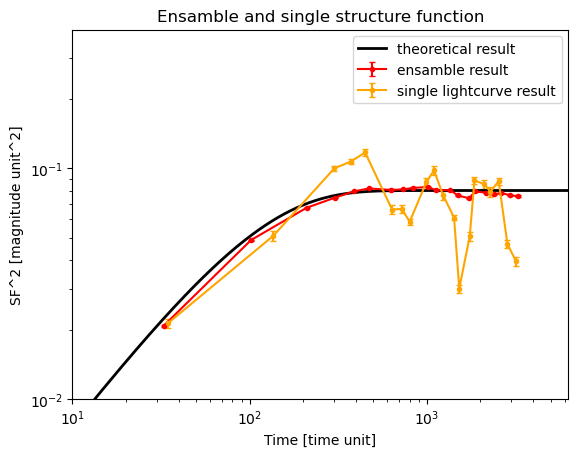

In [11]:
plt.figure()
plt.errorbar(res_sf2['dt'], res_sf2['sf2'], yerr=res_sf2['1_sigma'],
             marker='.', capsize=2, label='ensamble result', color='red')
plt.errorbar(res_one['dt'], res_one['sf2'], yerr=res_one['1_sigma'],
             marker='.', capsize=2, label='single lightcurve result', color='orange')
plt.plot(t_th, SF_th, marker='', label='theoretical result', 
         color='black', lw=2)
plt.yscale('log')
plt.xscale('log')
plt.title("Ensamble and single structure function")
plt.xlabel('Time [time unit]')
plt.ylabel('SF^2 [magnitude unit^2]')
plt.ylim(10**(-2), 10**(-0.4))
plt.xlim(10**(1), 10**(3.8))
plt.legend()
plt.show()

Let us discuss what is the meaning of these error bars. They are calculated from bootstrapping the sample, 
and as such, they should capture the inherent uncertainty of the stochastic process. In order to be less sensitive to the outliers, they are calculated by comparing the 84th and 16th quantiles of the distribution
of generated structure function results. The code below illustrates the procedure.

In [15]:
# For the same lightcurve as above, let us resample it 100 times and put the results in separate array
arg_container.estimate_err = False
res_resample_arr = np.zeros((100,20))
for i in range(100):  
    resample_arr = np.sort(np.random.choice(np.arange(0,200), size=len(y[j]), replace=True))
    res_resample = tape.analysis.calc_sf2(t[j][resample_arr], y[j][resample_arr], err[j][resample_arr],
                                          argument_container=arg_container)
    res_resample_arr[i]=res_resample['sf2'].values

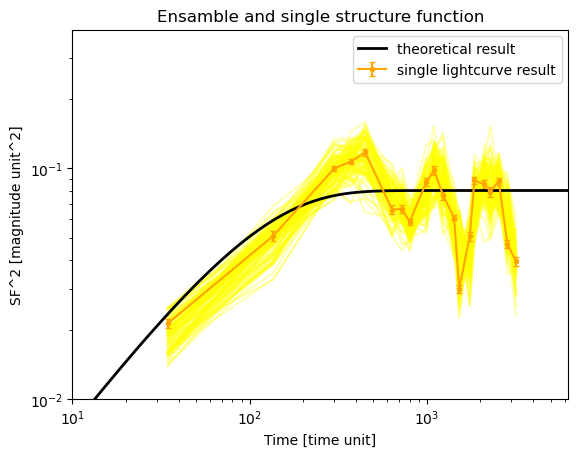

In [19]:
# Show all of the 100 results in faint yellow
plt.plot(res_one['dt'], res_resample_arr.transpose(), alpha=0.3, color='yellow')
plt.errorbar(res_one['dt'], res_one['sf2'], yerr=res_one['1_sigma'],
             marker='.', capsize=2, label='single lightcurve result', color='orange')
plt.plot(t_th, SF_th, marker='', label='theoretical result', 
         color='black', lw=2 )
plt.yscale('log')
plt.xscale('log')
plt.title("Ensamble and single structure function")
plt.xlabel('Time [time unit]')
plt.ylabel('SF^2 [magnitude unit^2]')
plt.ylim(10**(-2), 10**(-0.4))
plt.xlim(10**(1), 10**(3.8))
plt.legend()
plt.show()

Let us look at the distribution of results in the shortest time bin. With the orange line, we denote
the result from the non-resampled lightcurve, and we compare the error reported from the calculation
and the error computed ``manually'' above.

We see quite a difference between the errors we computed manually and from the code! 
This problem is captured in: https://github.com/lincc-frameworks/tape/issues/198

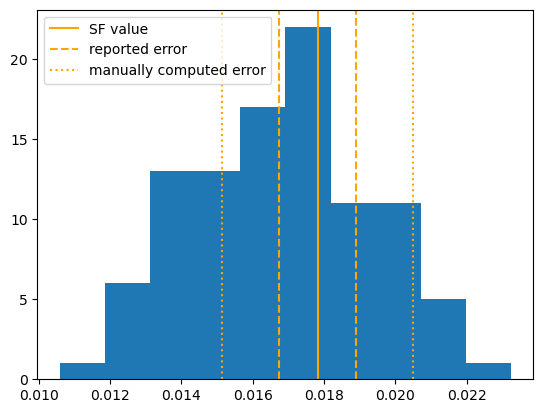

In [ ]:
plt.hist(res_resample_arr.transpose()[0])
err_manual = (np.quantile(res_resample_arr.transpose()[0], 0.84) -
              np.quantile(res_resample_arr.transpose()[0], 0.16)) /2  
plt.axvline(res_one['sf2'][0], color='orange', label='SF value')
plt.axvline(res_one['sf2'][0]+res_one['1_sigma'][0], color='orange', ls='--',
            label='reported error')
plt.axvline(res_one['sf2'][0]-res_one['1_sigma'][0], color='orange', ls='--')
plt.axvline(res_one['sf2'][0]+err_manual, color='orange', ls=':',
            label='manually computed error')
plt.axvline(res_one['sf2'][0]-err_manual, color='orange', ls=':')
plt.legend()

## Structure function methods

Numerous different definitions exist for structure calculation. This is because the original
formula is very sensitive to outliers (in a quadratic fashion), so a couple of outliers can
completely distort the results. Therefore, multiple different approaches exist which produce the same 
result as the original equation under certain assumptions, but are less sensitive to problems in the data.

To access these methods, specify the `sf_method` argument, as shown below.

In [ ]:
# This takes at the moment 3 minutes, 25 seconds 
arg_container = tape.analysis.structure_function.StructureFunctionArgumentContainer()


arg_container.sf_method = 'macleod_2012'
arg_container.combine = True
arg_container.bin_count_target = 100000
arg_container.calculation_repetitions = 1
res_macleod = ens.sf2( argument_container=arg_container)


arg_container.sf_method = 'bauer_2009a'
res_bauer_a = ens.sf2(argument_container=arg_container)

arg_container.sf_method = 'bauer_2009b'
res_bauer_b = ens.sf2(argument_container=arg_container)

arg_container.sf_method = 'schmidt_2010'
res_schmidt = ens.sf2(argument_container=arg_container)


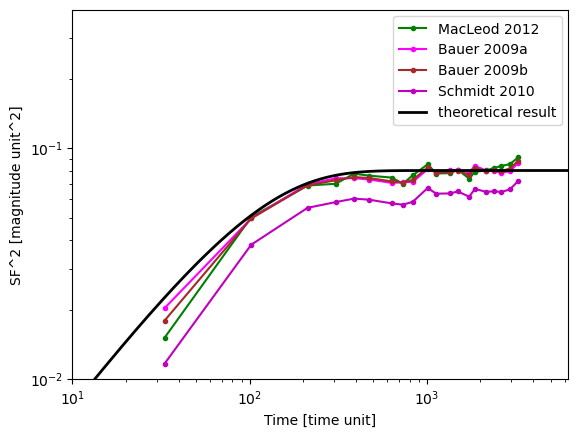

In [ ]:
# plt.plot(res_basic['dt'], res_basic['sf2'], 'b', label='Basic', lw = 3, marker = 'o')
plt.plot(res_macleod['dt'], res_macleod['sf2'], 'g',marker='.', label='MacLeod 2012')
plt.plot(res_bauer_a['dt'], res_bauer_a['sf2'], 'magenta',marker='.', label='Bauer 2009a')
plt.plot(res_bauer_b['dt'], res_bauer_b['sf2'], 'brown',marker='.', label='Bauer 2009b')
plt.plot(res_schmidt['dt'], res_schmidt['sf2'], 'm',marker='.', label='Schmidt 2010')
plt.plot(t_th, SF_th, marker='', label='theoretical result', 
         color='black', lw=2 )
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time [time unit]')
plt.ylabel('SF^2 [magnitude unit^2]')
plt.ylim(10**(-2), 10**(-0.4))
plt.xlim(10**(1), 10**(3.8))
plt.legend()